In [ ]:
import os
import sys
current_dir = os.getcwd()
grand_package_root = os.path.join(current_dir,'..')
sys.path.insert(0, grand_package_root)
print(f"Répertoire racine du package ajouté à sys.path : {grand_package_root}")

Répertoire racine du package ajouté à sys.path : /users/eleves-b/2023/serena.tannous/Desktop/PHY51171/EA_Project-20251209T130744Z-3-001/EA_Project/Analysis/..


In [ ]:
import numpy as np
import numpy.random as rnd
import itertools
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generate_binary_structure
from IPython import display
import pandas as pd
import time
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from Production.Exact_Energy import exact_1d_ising_energy, compute_relative_error
from Design.Ising import Configuration
from Production.RBM_GD import RBM
from Production.RBM_SR import RBMSR


In [ ]:
plt.rcParams.update({'font.size': 14})

plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.titlesize'] = 20

### Compare with different sample size

=== Training for n_samples = 200 ===


/tmp/ipython-input-1967252188.py:238: ComplexWarning: Casting complex values to real discards the imaginary part
  E_local = float(self.local_energy(temp_config))  # ensure scalar
/tmp/ipython-input-1459978721.py:221: ComplexWarning: Casting complex values to real discards the imaginary part
  E_local = float(self.local_energy(temp_config))  # ensure scalar


=== Training for n_samples = 600 ===
=== Training for n_samples = 1200 ===


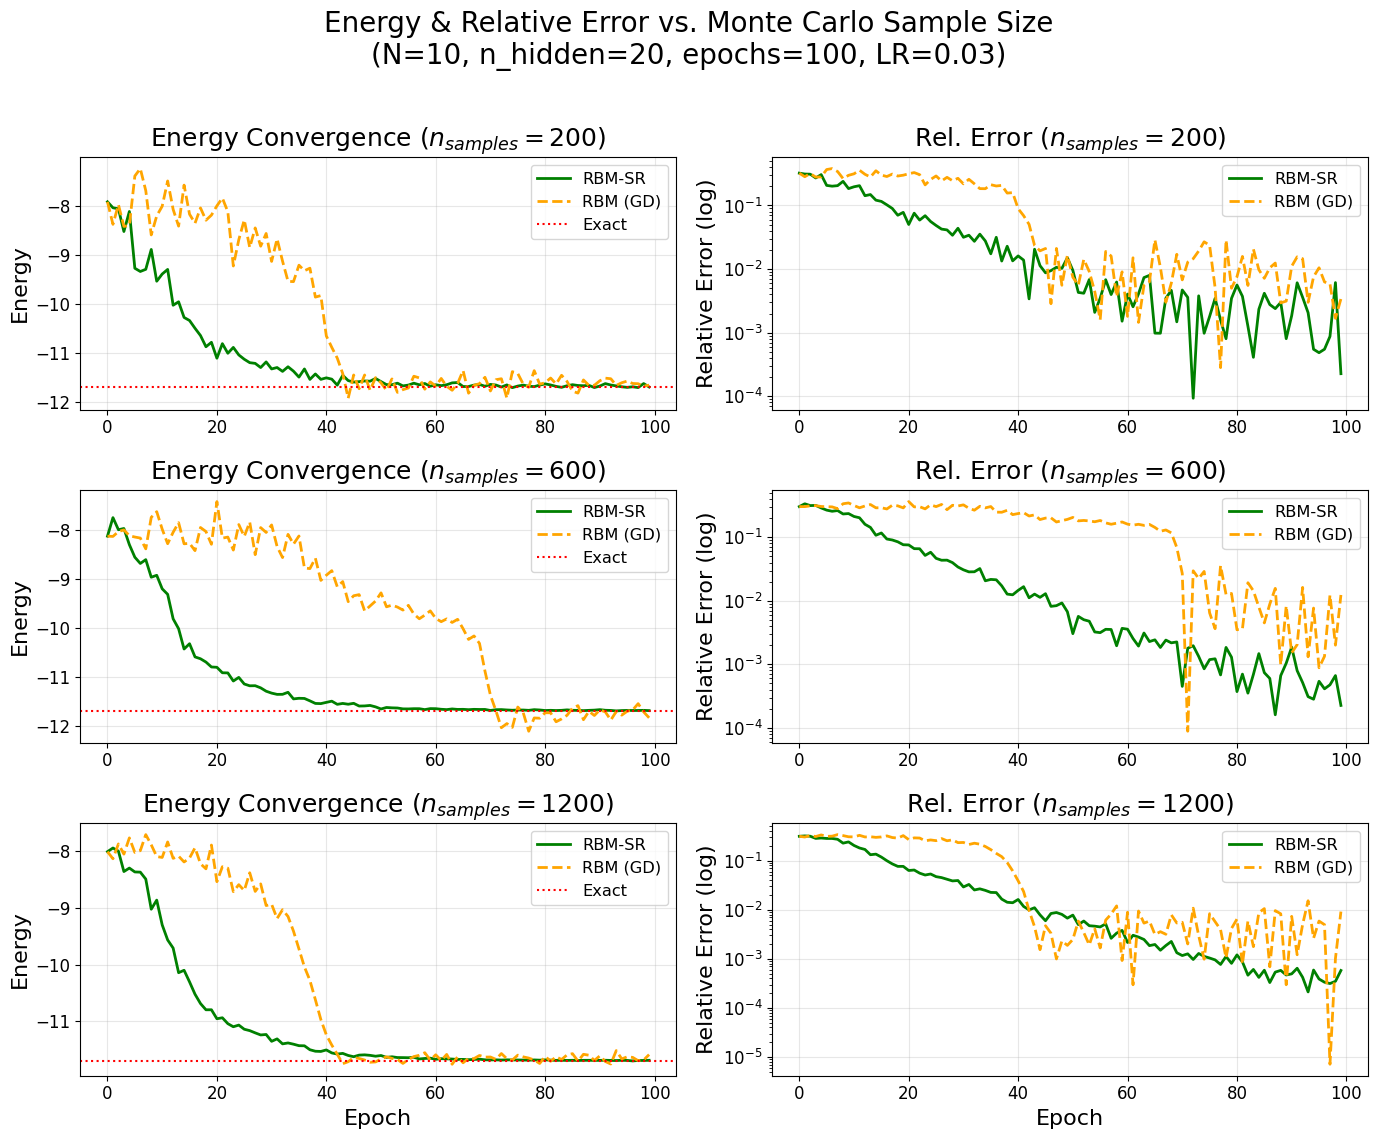

In [ ]:
#  General Parameters Definition (Fixed for this run)
N = 10                  # Fixed: Chain length (Number of visible units)
n_hidden = 20           # Fixed: Number of hidden units
epochs = 100            # Fixed: Total number of training epochs
learning_rate = 0.03    # Fixed: Learning rate for both optimizers
J = 1.0                 # Fixed: Ising coupling constant
H = 1                # Fixed: External magnetic field
# Variable: List of Monte Carlo sample sizes to iterate over
n_samples_list = [200, 600, 1200]
colors = ['blue', 'green', 'red', 'purple'] # Colors (Note: only green and orange are explicitly used below)

#  Figure Configuration: One Row per n_samples Value
# nrows = 3 (for 3 sample sizes)
# ncols = 2 (Energy plot and Error plot)
fig, axes = plt.subplots(
    nrows=len(n_samples_list),
    ncols=2,
    figsize=(14, 4 * len(n_samples_list))
)

# General title including the fixed parameters
fig.suptitle(f'Energy & Relative Error vs. Monte Carlo Sample Size\n(N={N}, n_hidden={n_hidden}, epochs={epochs}, LR={learning_rate})')

# Calculate the exact ground state energy
E_exact = exact_1d_ising_energy(N, J, H, periodic=True)[0]

# Loop over different Monte Carlo Sample Sizes (n_samples)
for i, n_samples_val in enumerate(n_samples_list):
    print(f"=== Training for n_samples = {n_samples_val} ===")

    # Both RBM-SR and RBM-GD are trained with the current n_samples_val
    rbm_sr = RBMSR(n_visible=N, n_hidden=n_hidden, seed=42)
    rbm_gd = RBM(n_visible=N, n_hidden=n_hidden, seed=42)

    #  RBM-SR Training (Stochastic Reconfiguration)
    # RBM-SR is generally more robust against noise (lower n_samples)
    energies_sr, rel_errors_sr = rbm_sr.train(
        n_epochs=epochs,
        n_samples_per_epoch=n_samples_val,
        learning_rate=learning_rate,
        J=J,
        H=H,
        verbose=False # Set to True to see epoch-by-epoch progress
    )

    # RBM (Gradient Descent) Training
    # RBM-GD is often more sensitive to noise (lower n_samples)
    energies_gd, rel_errors_gd = rbm_gd.train(
        n_epochs=epochs,
        n_samples_per_epoch=n_samples_val,
        learning_rate=learning_rate,
        J=J,
        H=H,
        verbose=False # Set to True to see epoch-by-epoch progress
    )

    # Select the axes for the current row (i)
    ax_energy = axes[i, 0]
    ax_error  = axes[i, 1]

    # Plot 1: Energy Convergence (Left Column)
    ax_energy.plot(energies_sr, label='RBM-SR', color='green', linewidth=2)
    ax_energy.plot(energies_gd, label='RBM (GD)', color='orange', linestyle='--', linewidth=2)
    # Exact energy reference line
    ax_energy.axhline(y=E_exact, color='r', linestyle=':', label='Exact')

    ax_energy.set_ylabel('Energy')
    ax_energy.set_title(f'Energy Convergence ($n_{{samples}}={n_samples_val}$)')
    ax_energy.legend(loc='upper right', fontsize='small')
    ax_energy.grid(True, alpha=0.3)

    # Plot 2: Relative Error (Right Column)
    # Logarithmic scale (semilogy) is used for the error
    ax_error.semilogy(np.abs(rel_errors_sr), label='RBM-SR', color='green', linewidth=2)
    ax_error.semilogy(np.abs(rel_errors_gd), label='RBM (GD)', color='orange', linestyle='--', linewidth=2)

    ax_error.set_ylabel('Relative Error (log)')
    ax_error.set_title(f'Rel. Error ($n_{{samples}}={n_samples_val}$)')
    ax_error.legend(loc='upper right', fontsize='small')
    ax_error.grid(True, alpha=0.3)

    # Add 'Epoch' label only on the bottom row to keep the plot clean
    if i == len(n_samples_list) - 1:
        ax_energy.set_xlabel('Epoch')
        ax_error.set_xlabel('Epoch')

# Adjust layout to prevent subplots from overlapping and allow space for suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()